## <center>Sentiment Analysis 🙂😐😠</center>

Problem Statement - In this challenge, the goal is to detect the sentiments of the natural occurring sentences.
Ground Truth contains 3 categorical values : Positive, Neutral, Negative

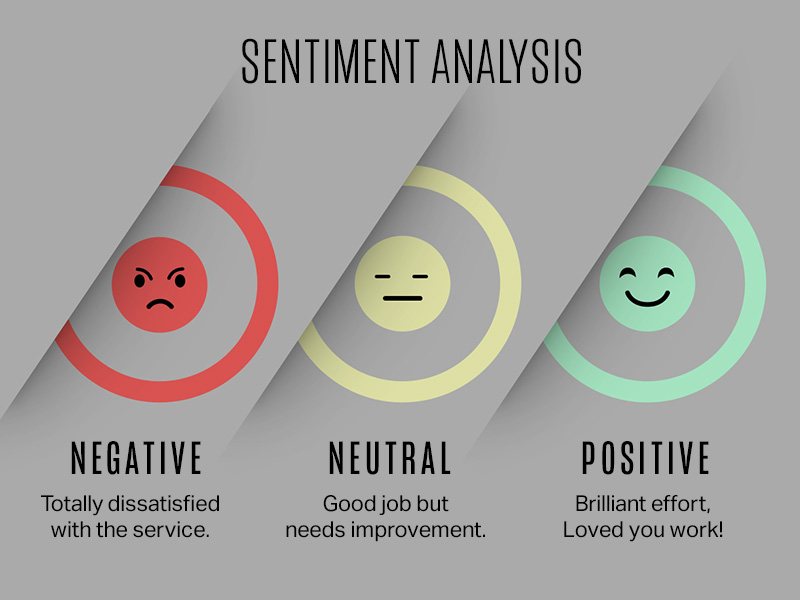


<b>Some background and application in real-world</b> : As the Social networking, customer support, and market research are where sentiment analysis is most frequently used. In social media, sentiment analysis is frequently used to examine how users feel about and talk about a brand or product. Organizations can use it to learn how various societal segments see various issues, ranging from hot topics to breaking news. With this knowledge, businesses may react swiftly to public sentiment.(-1)

---
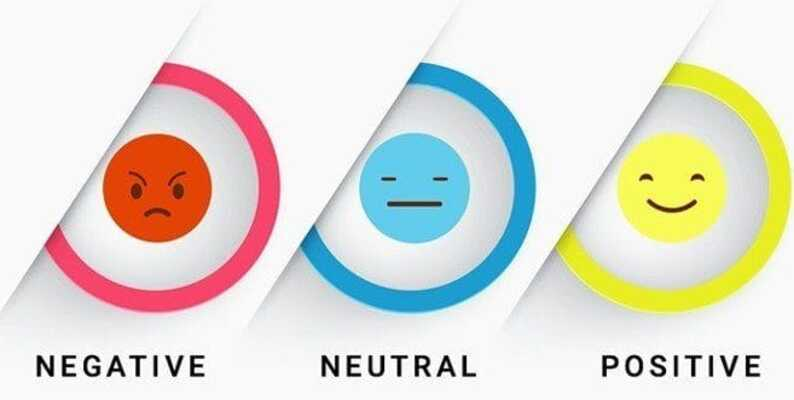
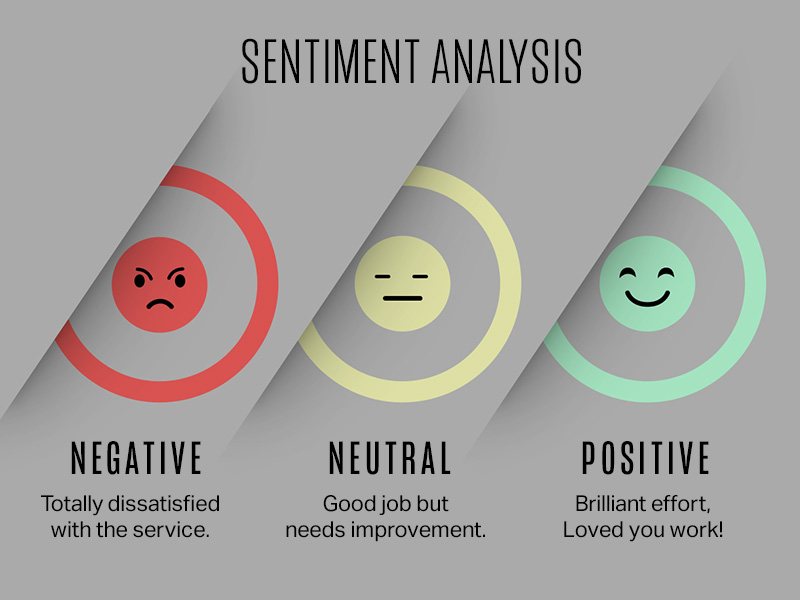
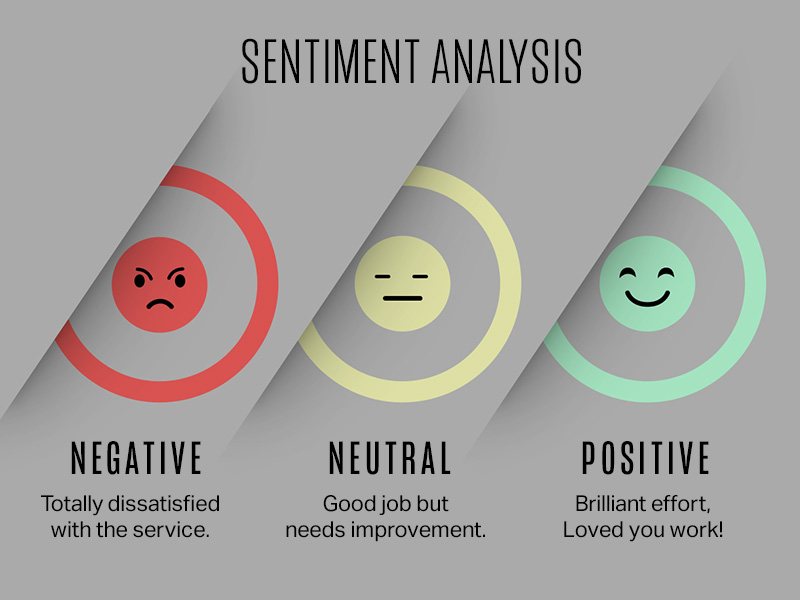

Let's start by importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import csv
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

Reading the data from the respective CSV files.

In [2]:
competiton_path = Path("/kaggle/input/sentiment-analysis-dataset") # Change this path as required
#dev_datasets = competiton_path / Path("dev-datasets")
#test_datasets = competiton_path / Path("test-datasets")

def load_csv(path):

    with open(path, 'r') as f:

        reader = csv.reader(f)

        data = list(reader)

    return data



train_data = load_csv(competiton_path / "train.csv")
dev_data = load_csv(competiton_path / "dev.csv")
test_data = load_csv(competiton_path / "test.csv")

# print number of rows and columns
print("Train data: ", len(train_data), len(train_data[0]))
print("Dev data: ", len(dev_data), len(dev_data[0]))
print("Test data: ", len(test_data), len(test_data[0]))

# Convert to pandas dataframe

train_df = pd.DataFrame(train_data[1:], columns=train_data[0])
dev_df = pd.DataFrame(dev_data[1:], columns=dev_data[0])
test_df = pd.DataFrame(test_data[1:], columns=test_data[0])

Train data:  92229 3
Dev data:  4856 2
Test data:  5111 2


We see that the dev and test data don't have their labels. Hence all the modelling activity is done only on the train data.

So let's have a look at the training data

In [3]:
train_df.head()

,text_id,sentence,gold_label
0,r1-0051002,"Cheers,\n\nDennis Nguyen\n416-879-6431",0
1,r1-0020356,May have to wait longer on holidays.,-1
2,r1-0058348,"I drove to vegas may 6th, to get my hair done.",0
3,r1-0080006,"In addition, I eat out often at various restau...",1
4,r1-0000827,Perhaps she was doing us a favor?,0


In [4]:
test_df.head()

,text_id,sentence
0,r1-0086521,A helpful valet at the Bellagio said it was a ...
1,r1-0044715,"People often ask ""what happened to the human c..."
2,r1-0060690,He explained there would be a diagnostic fee o...
3,r1-0016852,I had initially purchased a massage on Groupon.
4,r2-0006040,Primarily do high-end cars as they get referra...


In [5]:
print("Data type of Target: ", train_df['gold_label'].dtype)

print("Data type of Text_ID feature: ", train_df['sentence'].dtype)

print("Data type of Sentence feature: ", train_df['text_id'].dtype)

Data type of Target:  object
Data type of Text_ID feature:  object
Data type of Sentence feature:  object


In [6]:
# Missing values
print("NULL values check in training dataset", train_df.isnull().sum())

print("NULL values check in testing dataset", test_df.isnull().sum())

NULL values check in training dataset text_id       0
sentence      0
gold_label    0
dtype: int64
NULL values check in testing dataset text_id     0
sentence    0
dtype: int64


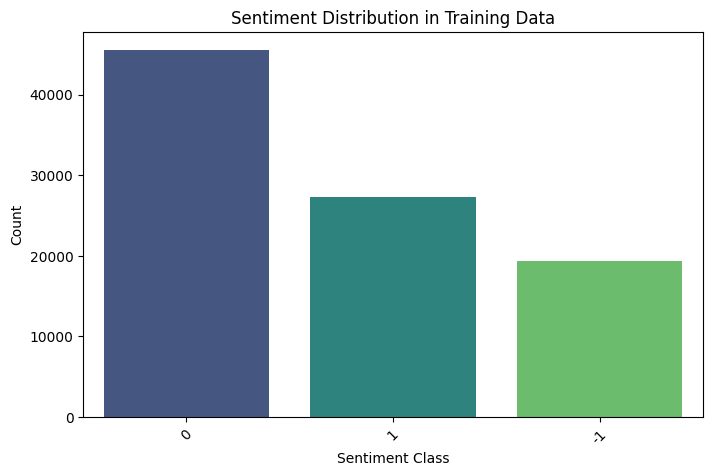

In [7]:
# Count the occurrences of each sentiment class
sentiment_counts = train_df['gold_label'].value_counts()

# Create a bar chart

plt.figure(figsize=(8, 5))

sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')

plt.title('Sentiment Distribution in Training Data')

plt.xlabel('Sentiment Class')

plt.ylabel('Count')

plt.xticks(rotation=45)

plt.show()

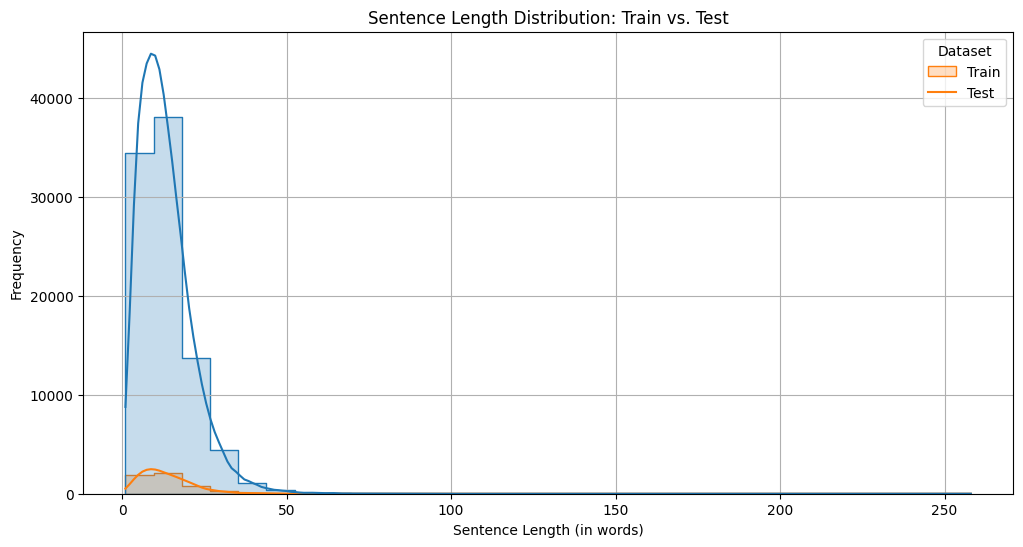

Train dataset: Mean sentence length = 13.24
Test dataset: Mean sentence length = 13.31


In [8]:
# Calculate sentence length

def calculate_sentence_lengths(dataframe, column_name):

    return dataframe[column_name].apply(lambda sentence: len(sentence.split())).tolist()

train_lengths = calculate_sentence_lengths(train_df, "sentence")

test_lengths = calculate_sentence_lengths(test_df, "sentence")

data = pd.DataFrame({

    "Sentence Length": train_lengths + test_lengths,

    "Dataset": ["Train"] * len(train_lengths) + ["Test"] * len(test_lengths)

})

# Plot the distributions
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x="Sentence Length", hue="Dataset", kde=True, bins=30, element="step")
plt.title("Sentence Length Distribution: Train vs. Test")
plt.xlabel("Sentence Length (in words)")
plt.ylabel("Frequency")
plt.legend(title="Dataset", labels=["Train", "Test"])
plt.grid()
plt.show()

# Print summary statistics
train_mean, test_mean = sum(train_lengths) / len(train_lengths), sum(test_lengths) / len(test_lengths)
print(f"Train dataset: Mean sentence length = {train_mean:.2f}")
print(f"Test dataset: Mean sentence length = {test_mean:.2f}")

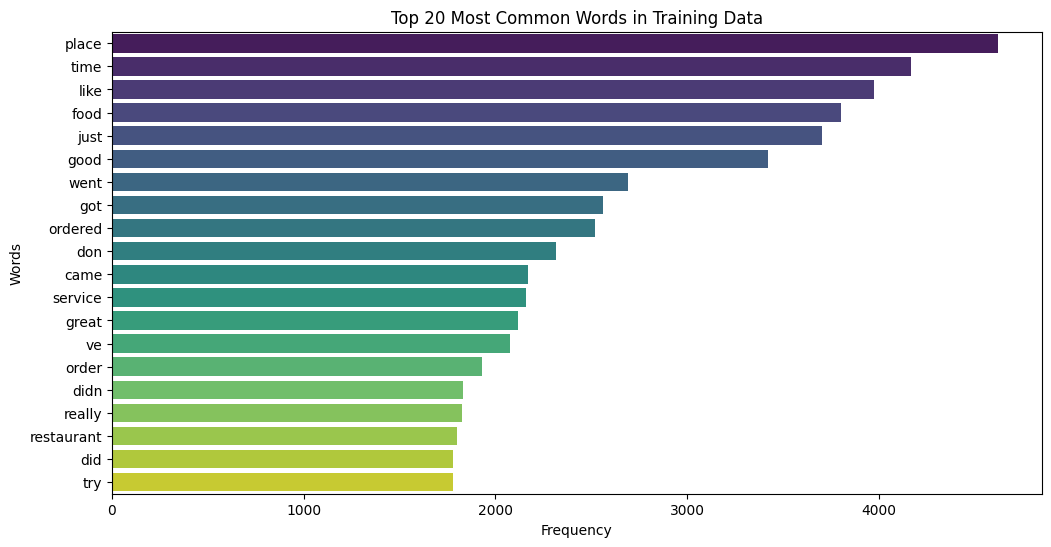

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer to count word frequencies
vectorizer = CountVectorizer(stop_words='english')
X_train_counts = vectorizer.fit_transform(train_df['sentence'])

# Sum the occurrences of each word
word_counts = X_train_counts.sum(axis=0)
word_freq = [(word, word_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)

# Get the top 20 words
top_words = word_freq[:20]
words, counts = zip(*top_words)

# Create a bar chart for the top 20 words
plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title('Top 20 Most Common Words in Training Data')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

## Feature extraction



Creating a TF-IDF vectorizer as an input to a model to classify the sentiments

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_Y = train_df["gold_label"]

# Create a TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(train_df['sentence'])

train_X = vectorizer.transform(train_df['sentence'])
dev_X = vectorizer.transform(dev_df['sentence'])
test_X = vectorizer.transform(test_df['sentence'])

In [11]:
train_X.shape

(92228, 31061)

In [12]:
dev_df.head()

,text_id,sentence
0,r2-0017684,They were really quiet during lunch hour on a ...
1,r1-0056793,"They were, however, delicious and because my h..."
2,r1-0005378,We opted for a desert beverages as opposed to ...
3,r1-0065594,"Eat, sleep, repeat."
4,r1-0031164,I watched a number of those people who were wa...


## Modelling

We'll have a look at different modelling strategies to use the TF-IDF vectors to classify sentiments

1. Logistic Regression

2. Simple feed forward neural networks

3. RNN

4. LSTM

### 1. Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

# Create a Logistic Regression model
model = LogisticRegression(class_weight='balanced', max_iter=500)
model.fit(train_X, train_Y)
train_score = model.score(train_X, train_Y)
print("Train accuracy: ", train_score)

Train accuracy:  0.7411957323155658


In [14]:
dev_predictions = model.predict(dev_X)
dev_df["predictions"] = dev_predictions

test_predictions = model.predict(test_X)
test_df["predictions"] = test_predictions

dev_df.to_csv("dev_predictions.csv", index=False)
test_df.to_csv("test_predictions.csv", index=False)

def create_submission(df, filename):

    with open(filename, 'w') as f:

        for index, row in df.iterrows():

            f.write(row["predictions"] + "\n")

create_submission(dev_df, "dev_answer.txt")
create_submission(test_df, "test_answer.txt")

### 2. Simple Neural Network



Let's create a simple neural network using PyTorch

In [15]:
# Importing libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.random import manual_seed
manual_seed(42)

In [16]:
class SimpleClassifier(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):

        super(SimpleClassifier, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size) # applies linear transformation to the incoming data y=xA^T + b : syntax : Linear(size of each I/P sample, size of each O/P sample)

        self.relu = nn.ReLU() # Rectified Linear Unit activation func ReLU(x) = max(0, x)

        self.fc2 = nn.Linear(hidden_size, output_size)

        self.softmax = nn.Softmax(dim=1) # Softmax activation for multi-class output

    def forward(self, x):

        x = self.fc1(x)

        x = self.relu(x)

        x = self.fc2(x)

        return x

Let's create a pytorch dataset class to injest the data and use it for training.



Pytorch provide with 2 helper methods to do data injestion:

1. Dataset

2. DataLoader



`Dataset` allows us to play with each data sample and wrap it for use by the `DataLoader`. The `DataLoader` helps in creating batches and combine the samples for use in modelling.



Find more details in [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [17]:
from torch.utils.data import Dataset
from scipy.sparse import coo_matrix

class SimpleClassifierDataset(Dataset):

    def __init__(self, X, Y=None):

        self.X = self._convert_to_tensor(X)

        self.Y = torch.tensor(Y, dtype=torch.long) + 1

    def __len__(self):

        return len(self.X)

    def __getitem__(self, idx):

        return self.X[idx], self.Y[idx]

    @classmethod

    def _convert_to_tensor(self, x):

        # Assuming train_X is a DataFrame

        x = coo_matrix(x)

        # Convert train_X to torch sparse tensor

        return torch.sparse_coo_tensor(

            indices=torch.LongTensor([x.row, x.col]),

            values=torch.FloatTensor(x.data),

            size=x.shape,

            dtype=torch.float32

        )

def collate_fun(batch):

    X_dense = [item[0].to_dense() for item in batch]  # Convert each X to dense

    Y = [item[1] for item in batch]

    return torch.stack(X_dense), torch.tensor(Y)



train_Y_numeric = np.array(train_Y).astype(int)

train_dataset = SimpleClassifierDataset(train_X, train_Y_numeric)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,  collate_fn=collate_fun) # we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting

test_X_tensor = SimpleClassifierDataset._convert_to_tensor(test_X)

dev_X_tensor = SimpleClassifierDataset._convert_to_tensor(dev_X)

Let's make the scoring function and the training loop to train the `SimpleClassifier`. The scoring function computes the accuracy of the model based on the predictions. We use the `accuracy_score` function of scikit-learn to compute the accuracy.



Training the model requires few basic steps:

1. Create the model by calling the contructor to `SimpleClassifier`

2. Create the loss function or the "criterion". Here we use the Cross Entropy Loss as we are working with sentiment classification task consisting of 3 sentiments ("positive", "neutral", and "negative" represented as 1, 0, -1 respectively.)

3. Create the optimizer to update the weights of the model. We use the Adam optimizer here. Read more about the optimizer [here](https://pytorch.org/docs/stable/optim.html)

4. Training loop of the model. We use 20 epochs here you can change the number of epochs to see the performance of the model. In each epoch we do the following:

    1. load a batch of data

    2. zero the gradients

    3. Make a forward pass of the inputs on the model and collect the predictions (here we collect the logits output by the model)

    4. Compute the loss by comparing the predictions with the actual labels

    5. Backpropagate the loss to update the weights using `loss.backward()`

    6. Update the weights using the optimizer by calling `optimizer.step()`

    7. Compute the accuracy of the model using the scoring function

    8. Compute predictions using the test and dev.

5. Save the model using pytorch's `torch.save` method.


In [18]:
def score(model, X, Y):

    model.eval()    # Use the model in evaluation mode

    X = X.to("cuda")    # move the tensors to GPU

    outputs = model(X)    # obtain the model output (logits)

    _, predicted = torch.max(outputs, 1)    # Select the prediction made by the model using the output logits

    predicted = predicted.cpu()

    Y = Y.cpu()

    return accuracy_score(Y, predicted)   # compute the accuracy



def predict(model, X):

    model.eval()    # Use the model in evaluation mode

    X = X.to("cuda")    # move the tensors to GPU

    outputs = model(X)    # obtain the model output (logits)

    _, predicted = torch.max(outputs, 1)    # Select the prediction made by the model using the output logits

    predicted = predicted.cpu()   # Move the predictions to cpu so that they can be inserted into a file

    return predicted



def fit_and_score(train_dataloader, valid_X=None, test_X=None):

    model = SimpleClassifier(input_size=31061, hidden_size=128, output_size=3)   # Initialize a simple model. 31061 is the number of dimensions from the tfidf vectors obtained above

    criterion = nn.CrossEntropyLoss()   # We are using the cross entropy loss - Σ yi log(pi) , i = 1 to m , pi is predicted probability, lower is better

    optimizer = torch.optim.Adam(model.parameters())   # Using the Adam optimizer



    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce learning rate after every 10 epochs



    epochs = 20   # We run the model for 20 epochs



    model = model.to("cuda")

    criterion = criterion.to("cuda")



    # TRAINING LOOP

    for epoch in tqdm(range(epochs), desc="Training", unit="epoch", total=epochs, ncols=100):

        model.train()   # set the model to training mode

        train_score = 0

        for train_X, train_Y, in train_dataloader: # grab the train_X and train_Y from the dataloader

            train_X = train_X.to("cuda")

            train_Y = train_Y.to("cuda")

            optimizer.zero_grad()   # set the optimizer to 0 gradients. Now the optimizer will keep track of fresh gradients

            outputs = model(train_X)    # Obtain the output logits of the model

            loss = criterion(outputs, train_Y)   # calculate the loss between the output logits and the predicted outputs

            loss.backward()   # Compute the gradients by pushing the loss backwards.

            optimizer.step()   # Call the optimizer.step() to add the gradients to the parameters based on the optimizer's formula

            train_score += score(model, train_X, train_Y)

        train_score /= len(train_dataloader)

        if valid_X is not None:

            valid_predictions = predict(model, valid_X)

        if test_X is not None:

            test_predictions = predict(model, test_X)

        print(f"Epoch {epoch+1}/{epochs}, Train score: {train_score}")

        #scheduler.step()  # Adjust learning rate



    torch.save(model.state_dict(), "Simple_classifier_model.pth")   # Save the model using torch.save() - A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor.

    return train_score, valid_predictions, test_predictions # we return only the final train score and predictions

    #return train_score, valid_predictions

train_score, dev_predictions, test_predictions = fit_and_score(train_dataloader, valid_X=dev_X_tensor, test_X=test_X_tensor)

#train_score, dev_predictions = fit_and_score(train_dataloader, valid_X=dev_X_tensor)

Training:   5%|██▌                                               | 1/20 [02:35<49:09, 155.22s/epoch]

Epoch 1/20, Train score: 0.6606074401664932


Training:  10%|█████                                             | 2/20 [05:08<46:17, 154.30s/epoch]

Epoch 2/20, Train score: 0.7474419007977801


Training:  15%|███████▌                                          | 3/20 [07:43<43:43, 154.29s/epoch]

Epoch 3/20, Train score: 0.8000346860908776


Training:  20%|██████████                                        | 4/20 [10:18<41:12, 154.52s/epoch]

Epoch 4/20, Train score: 0.8510665972944849


Training:  25%|████████████▌                                     | 5/20 [12:52<38:40, 154.67s/epoch]

Epoch 5/20, Train score: 0.8978277835587929


Training:  30%|███████████████                                   | 6/20 [15:27<36:05, 154.70s/epoch]

Epoch 6/20, Train score: 0.9335436177592785


Training:  35%|█████████████████▌                                | 7/20 [18:01<33:28, 154.54s/epoch]

Epoch 7/20, Train score: 0.9602735865417967


Training:  40%|████████████████████                              | 8/20 [20:36<30:53, 154.49s/epoch]

Epoch 8/20, Train score: 0.9767819979188346


Training:  45%|██████████████████████▌                           | 9/20 [23:10<28:18, 154.40s/epoch]

Epoch 9/20, Train score: 0.9864290669441554


Training:  50%|████████████████████████▌                        | 10/20 [25:46<25:47, 154.75s/epoch]

Epoch 10/20, Train score: 0.991263440860215


Training:  55%|██████████████████████████▉                      | 11/20 [28:20<23:12, 154.77s/epoch]

Epoch 11/20, Train score: 0.9942659556018036


Training:  60%|█████████████████████████████▍                   | 12/20 [30:54<20:36, 154.57s/epoch]

Epoch 12/20, Train score: 0.995610041623309


Training:  65%|███████████████████████████████▊                 | 13/20 [33:29<18:01, 154.54s/epoch]

Epoch 13/20, Train score: 0.996477193895248


Training:  70%|██████████████████████████████████▎              | 14/20 [36:03<15:26, 154.44s/epoch]

Epoch 14/20, Train score: 0.9968132154006244


Training:  75%|████████████████████████████████████▊            | 15/20 [38:38<12:52, 154.44s/epoch]

Epoch 15/20, Train score: 0.9969866458550122


Training:  80%|███████████████████████████████████████▏         | 16/20 [41:12<10:17, 154.28s/epoch]

Epoch 16/20, Train score: 0.9972251127297953


Training:  85%|█████████████████████████████████████████▋       | 17/20 [43:45<07:42, 154.06s/epoch]

Epoch 17/20, Train score: 0.9972901491501908


Training:  90%|████████████████████████████████████████████     | 18/20 [46:19<05:07, 153.88s/epoch]

Epoch 18/20, Train score: 0.9973877037807839


Training:  95%|██████████████████████████████████████████████▌  | 19/20 [48:51<02:33, 153.59s/epoch]

Epoch 19/20, Train score: 0.9973551855705862


Training: 100%|█████████████████████████████████████████████████| 20/20 [51:25<00:00, 154.27s/epoch]

Epoch 20/20, Train score: 0.9976153312521678


In [19]:
dev_df["predictions"] = dev_predictions - 1

test_df["predictions"] = test_predictions - 1


dev_df.to_csv("dev_neural_net_answer.csv", index=False)

test_df.to_csv("test_neural_net_answer.csv", index=False)


def create_submission(df, filename):

    with open(filename, 'w') as f:

        for index, row in df.iterrows():

            f.write(str(row["predictions"]) + "\n")


create_submission(dev_df, "dev_neural_net_answer.txt")

create_submission(test_df, "test_neural_net_answer.txt")

### 3. RNN

In [20]:
class RNNClassifier(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):

        super(RNNClassifier, self).__init__()

        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, nonlinearity='tanh')

        self.fc = nn.Linear(hidden_dim, output_dim)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        x = x.unsqueeze(1)  # Add sequence length dimension (batch_size, seq_len, input_dim)

        _, hidden = self.rnn(x)

        out = self.fc(hidden[-1])

        return self.softmax(out)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model initialization

input_dim = train_X.shape[1]  # Number of features from TfidfVectorizer

hidden_dim = 128

output_dim = 3

num_layers = 1


rnn_model = RNNClassifier(input_dim, hidden_dim, output_dim, num_layers).to(device)


# Loss and optimizer

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(rnn_model.parameters(), weight_decay=1e-5)

# Training loop

num_epochs = 10

for epoch in range(num_epochs):

    rnn_model.train()

    epoch_loss = 0

    correct = 0

    total = 0

    all_predictions = []

    all_labels = []

    for train_X, train_Y, in train_dataloader:

        train_X, train_Y = train_X.to(device), train_Y.to(device)

        # Forward pass

        outputs = rnn_model(train_X)

        loss = criterion(outputs, train_Y)

        # Backward pass and optimization

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())

        all_labels.extend(train_Y.cpu().numpy())

        total += train_Y.size(0)

        correct += (predicted == train_Y).sum().item()

    accuracy = correct / total

    f1 = f1_score(all_labels, all_predictions, average='weighted')  # Weighted F1 for multiclass

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')

Epoch [1/10], Loss: 2614.2209, Accuracy: 0.6350, F1 Score: 0.6051
Epoch [2/10], Loss: 2421.0729, Accuracy: 0.7046, F1 Score: 0.6958
Epoch [3/10], Loss: 2369.6813, Accuracy: 0.7258, F1 Score: 0.7187
Epoch [4/10], Loss: 2345.5584, Accuracy: 0.7343, F1 Score: 0.7282
Epoch [5/10], Loss: 2327.0370, Accuracy: 0.7409, F1 Score: 0.7352
Epoch [6/10], Loss: 2314.9873, Accuracy: 0.7460, F1 Score: 0.7406
Epoch [7/10], Loss: 2302.3641, Accuracy: 0.7509, F1 Score: 0.7458
Epoch [8/10], Loss: 2293.7472, Accuracy: 0.7544, F1 Score: 0.7494
Epoch [9/10], Loss: 2283.6951, Accuracy: 0.7584, F1 Score: 0.7537
Epoch [10/10], Loss: 2274.9881, Accuracy: 0.7615, F1 Score: 0.7568


In [22]:
from torch.utils.data import DataLoader, TensorDataset

rnn_model.eval()

test_X_dense = test_X.toarray()

test_datasets = TensorDataset(torch.tensor(test_X_dense, dtype=torch.float32))

test_loader = DataLoader(test_datasets, batch_size=32, shuffle=False)

test_predictions = []

with torch.no_grad():

    for X_batch in test_loader:

        X_batch = X_batch[0].to(device)

        outputs = rnn_model(X_batch)

        _, predicted = torch.max(outputs, 1)

        test_predictions.extend(predicted.cpu().numpy())

test_predictions = np.array(test_predictions) - 1

test_df["predictions"] = test_predictions

test_df.to_csv("test_rnn_answer.csv", index=False)

def create_submission(df, filename):

    with open(filename, 'w') as f:

        for index, row in df.iterrows():

            f.write(str(row["predictions"]) + "\n")

create_submission(test_df, "test_rnn_answer.txt")

### 4. LSTM

In [23]:
class LSTMClassifier(nn.Module):

  def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):

    super(LSTMClassifier, self).__init__()

    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

    self.fc = nn.Linear(hidden_dim, output_dim)

    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):

    x = x.unsqueeze(1)  # Add sequence length dimension (batch_size, seq_len, input_dim)

    _, (hidden, _) = self.lstm(x)

    out = self.fc(hidden[-1])

    return self.softmax(out)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model initialization

input_dim = train_X.shape[1]  # Number of features from TfidfVectorizer

hidden_dim = 128

output_dim = 3

num_layers = 1

lstm_model = LSTMClassifier(input_dim, hidden_dim, output_dim, num_layers).to(device)

# Loss and optimizer

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(lstm_model.parameters(), weight_decay=1e-5)


# Training loop

num_epochs = 10

for epoch in range(num_epochs):

    lstm_model.train()

    epoch_loss = 0

    correct = 0

    total = 0

    all_predictions = []

    all_labels = []

    for train_X, train_Y, in train_dataloader:

        train_X, train_Y = train_X.to(device), train_Y.to(device)

        # Forward pass

        outputs = lstm_model(train_X)

        loss = criterion(outputs, train_Y)

        # Backward pass and optimization

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())

        all_labels.extend(train_Y.cpu().numpy())

        total += train_Y.size(0)

        correct += (predicted == train_Y).sum().item()

    accuracy = correct / total

    f1 = f1_score(all_labels, all_predictions, average='weighted')  # Weighted F1 for multiclass

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')

Epoch [1/10], Loss: 2646.2333, Accuracy: 0.6226, F1 Score: 0.5870
Epoch [2/10], Loss: 2430.4753, Accuracy: 0.7011, F1 Score: 0.6919
Epoch [3/10], Loss: 2372.8604, Accuracy: 0.7245, F1 Score: 0.7175
Epoch [4/10], Loss: 2335.7448, Accuracy: 0.7393, F1 Score: 0.7332
Epoch [5/10], Loss: 2311.8448, Accuracy: 0.7481, F1 Score: 0.7426
Epoch [6/10], Loss: 2292.9266, Accuracy: 0.7561, F1 Score: 0.7511
Epoch [7/10], Loss: 2278.7942, Accuracy: 0.7614, F1 Score: 0.7567
Epoch [8/10], Loss: 2266.2676, Accuracy: 0.7659, F1 Score: 0.7614
Epoch [9/10], Loss: 2257.7867, Accuracy: 0.7692, F1 Score: 0.7647
Epoch [10/10], Loss: 2248.9661, Accuracy: 0.7726, F1 Score: 0.7684


In [25]:
from torch.utils.data import DataLoader, TensorDataset

lstm_model.eval()

test_X_dense = test_X.toarray()

test_datasets = TensorDataset(torch.tensor(test_X_dense, dtype=torch.float32))

test_loader = DataLoader(test_datasets, batch_size=32, shuffle=False)

test_predictions = []


with torch.no_grad():

    for X_batch in test_loader:

        X_batch = X_batch[0].to(device)

        outputs = lstm_model(X_batch)

        _, predicted = torch.max(outputs, 1)

        test_predictions.extend(predicted.cpu().numpy())

test_predictions = np.array(test_predictions) - 1

test_df["predictions"] = test_predictions

test_df.to_csv("test_lstm_net_answer.csv", index=False)

def create_submission(df, filename):

    with open(filename, 'w') as f:

        for index, row in df.iterrows():

            f.write(str(row["predictions"]) + "\n")

create_submission(test_df, "test_lstm_net_answer.txt")